In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.linalg import pinv, norm
from sklearn.preprocessing import normalize

from HW1 import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 圖片來源種類

In [2]:
source='star'

# read LightSource.txt
讀取光源

In [3]:
with open("test/{}/LightSource.txt".format(source),'r') as f:
    L = []
    for l in f.readlines():
        l = l.replace('\n','').replace('(','').replace(')','').split(' ')[1].split(',')
        l = [int(i) for i in l]
        L.append(l)

# to array        
L = np.array(L)
# normalize
L = normalize(L)

# read images
讀取影像

In [4]:
img1 = read_bmp('test/{}/pic1.bmp'.format(source))
h = img1.shape[0]
w = img1.shape[1]

In [5]:
img1 = read_bmp('test/{}/pic1.bmp'.format(source)).reshape(-1)
img2 = read_bmp('test/{}/pic2.bmp'.format(source)).reshape(-1)
img3 = read_bmp('test/{}/pic3.bmp'.format(source)).reshape(-1)
img4 = read_bmp('test/{}/pic4.bmp'.format(source)).reshape(-1)
img5 = read_bmp('test/{}/pic5.bmp'.format(source)).reshape(-1)
img6 = read_bmp('test/{}/pic6.bmp'.format(source)).reshape(-1)

In [6]:
I = np.vstack((img1,img2,img3,img4,img5,img6))
I.shape

(6, 14400)

# KdN
利用pesudo-inverse計算KdN

In [7]:
KdN = pinv((L.T@L))@L.T@I
KdN = KdN.T  # 需要再轉置一次，畫出來結果才是對的

In [8]:
# 正規化
N = normalize(KdN)

# 影像呈現

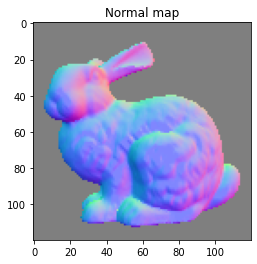

In [9]:
normal_visualization(N)

# Mask
製作mask判斷使用哪個方向向量

In [10]:
N_copy = N.reshape((w,w,3))

Mask = np.zeros((w,h))
for x in range(w):
    for y in range(h):
        if (N_copy[x,y] == np.array([0,0,0])).all():
            Mask[x,y] = 0
        else:
            Mask[x,y] = 1

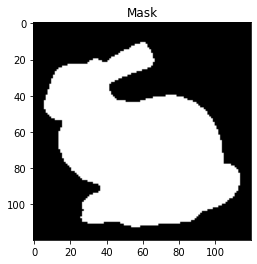

In [11]:
mask_visualization(Mask)

# Surface Reconstruction

In [13]:
s = w * h
M = np.zeros((2 * s, s))
V = np.zeros((2 * s, 1))


index = {}
c = 0
for i in range(w):
    for j in range(h):
        index[j,i] = c
        c+=1

In [14]:
# 製作index，紀錄2維時的index位置
index

{(0, 0): 0,
 (1, 0): 1,
 (2, 0): 2,
 (3, 0): 3,
 (4, 0): 4,
 (5, 0): 5,
 (6, 0): 6,
 (7, 0): 7,
 (8, 0): 8,
 (9, 0): 9,
 (10, 0): 10,
 (11, 0): 11,
 (12, 0): 12,
 (13, 0): 13,
 (14, 0): 14,
 (15, 0): 15,
 (16, 0): 16,
 (17, 0): 17,
 (18, 0): 18,
 (19, 0): 19,
 (20, 0): 20,
 (21, 0): 21,
 (22, 0): 22,
 (23, 0): 23,
 (24, 0): 24,
 (25, 0): 25,
 (26, 0): 26,
 (27, 0): 27,
 (28, 0): 28,
 (29, 0): 29,
 (30, 0): 30,
 (31, 0): 31,
 (32, 0): 32,
 (33, 0): 33,
 (34, 0): 34,
 (35, 0): 35,
 (36, 0): 36,
 (37, 0): 37,
 (38, 0): 38,
 (39, 0): 39,
 (40, 0): 40,
 (41, 0): 41,
 (42, 0): 42,
 (43, 0): 43,
 (44, 0): 44,
 (45, 0): 45,
 (46, 0): 46,
 (47, 0): 47,
 (48, 0): 48,
 (49, 0): 49,
 (50, 0): 50,
 (51, 0): 51,
 (52, 0): 52,
 (53, 0): 53,
 (54, 0): 54,
 (55, 0): 55,
 (56, 0): 56,
 (57, 0): 57,
 (58, 0): 58,
 (59, 0): 59,
 (60, 0): 60,
 (61, 0): 61,
 (62, 0): 62,
 (63, 0): 63,
 (64, 0): 64,
 (65, 0): 65,
 (66, 0): 66,
 (67, 0): 67,
 (68, 0): 68,
 (69, 0): 69,
 (70, 0): 70,
 (71, 0): 71,
 (72, 0): 72

In [15]:
# 用Mask來判斷條件並製作 M & V
i_row_pointer = 0
j_row_pointer = s


for j in range(h):
    for i in range(w):
        nx = N_copy[i][j][0]
        ny = N_copy[i][j][1]
        nz = N_copy[i][j][2]
        
        '''超過圖片範圍就丟棄'''
        if i-1>0 and j-1>0 and i+1<120 and j+1<120:

            M[i_row_pointer][index[(i,j)]]   = -1       # (i,j)
            M[j_row_pointer][index[(i,j)]]   = -1       # (i,j)

            '''填表'''
            if Mask[i,j+1]>0 and Mask[i-1,j]>0:           # 如果東北方向存在
                M[i_row_pointer][index[(i,j+1)]] = 1        # (i,j+1)
                M[j_row_pointer][index[(i-1,j)]] = 1        # (i-1,j)
                V[i_row_pointer] = -nx/nz if nz!=0 else 0 
                V[j_row_pointer] = -ny/nz if nz!=0 else 0

            elif Mask[i,j-1]>0 and Mask[i-1,j]>0:         # 如果西北方向存在(東不存在)
                M[i_row_pointer][index[(i,j-1)]] = 1        # (i,j-1)
                M[j_row_pointer][index[(i-1,j)]] = 1        # (i-1,j)
                V[i_row_pointer] = nx/nz if nz!=0 else 0 
                V[j_row_pointer] = -ny/nz if nz!=0 else 0

            elif Mask[i,j+1]>0 and Mask[i+1,j]>0:         # 如果東南方向存在(北不存在)
                M[i_row_pointer][index[(i,j+1)]] = 1        # (i,j+1)
                M[j_row_pointer][index[(i+1,j)]] = 1        # (i+1,j)
                V[i_row_pointer] = -nx/nz if nz!=0 else 0 
                V[j_row_pointer] = ny/nz if nz!=0 else 0

            elif Mask[i,j-1]>0 and Mask[i+1,j]>0:        # 如果西南方向存在(北、東不存在)
                M[i_row_pointer][index[(i,j-1)]] = 1        # (i,j-1)
                M[j_row_pointer][index[(i+1,j)]] = 1        # (i+1,j)
                V[i_row_pointer] = nx/nz if nz!=0 else 0 
                V[j_row_pointer] = ny/nz if nz!=0 else 0
            

        i_row_pointer += 1
        j_row_pointer += 1

In [16]:
# 算出z
z = pinv(M.T@M)@M.T@V

In [19]:
# reshape z
z_r = np.reshape(z,(w,h),order='F')

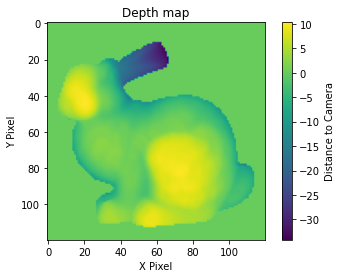

In [20]:
depth_visualization(z_r)

In [ ]:
# save 3D ply

In [26]:
save_ply(z_r,"./bunny.ply")

In [28]:
show_ply("./bunny.ply")